In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# **加载数据集**
# **并将图片transform成同一格式用于训练**

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/caltech256'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

##调用gpu进行加速
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **可视化部分数据集**

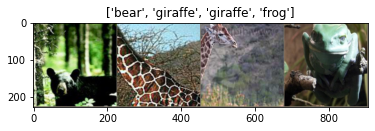

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


##可视化部分数据
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

##展示图片以及对应label
imshow(out, title=[class_names[x] for x in classes])

# **定义训练函数**

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# **可视化训练成果**

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **加载预训练模型**

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1677 Acc: 0.5692
val Loss: 0.4795 Acc: 0.8093

Epoch 1/24
----------
train Loss: 0.8392 Acc: 0.7026
val Loss: 0.3031 Acc: 0.8911

Epoch 2/24
----------
train Loss: 0.8263 Acc: 0.7128
val Loss: 0.3113 Acc: 0.8872

Epoch 3/24
----------
train Loss: 0.9619 Acc: 0.6795
val Loss: 0.3654 Acc: 0.8833

Epoch 4/24
----------
train Loss: 0.7831 Acc: 0.7462
val Loss: 0.2813 Acc: 0.9222

Epoch 5/24
----------
train Loss: 0.5912 Acc: 0.8051
val Loss: 0.5896 Acc: 0.8327

Epoch 6/24
----------
train Loss: 0.6063 Acc: 0.7897
val Loss: 0.4244 Acc: 0.8560

Epoch 7/24
----------
train Loss: 0.5983 Acc: 0.8205
val Loss: 0.1872 Acc: 0.9300

Epoch 8/24
----------
train Loss: 0.4669 Acc: 0.8564
val Loss: 0.1446 Acc: 0.9533

Epoch 9/24
----------
train Loss: 0.4684 Acc: 0.8538
val Loss: 0.1557 Acc: 0.9572

Epoch 10/24
----------
train Loss: 0.4084 Acc: 0.8590
val Loss: 0.1621 Acc: 0.9494

Epoch 11/24
----------
train Loss: 0.4274 Acc: 0.8692
val Loss: 0.1621 Acc: 0.9339

Ep

# **可视化测试集**

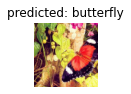

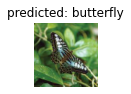

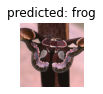

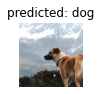

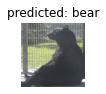

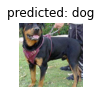

In [17]:
visualize_model(model_ft)

# **冻结全连层以外的所有卷积层**

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# **再次进行训练**

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3181 Acc: 0.4872
val Loss: 0.3735 Acc: 0.8988

Epoch 1/24
----------
train Loss: 0.7811 Acc: 0.7282
val Loss: 0.2396 Acc: 0.9222

Epoch 2/24
----------
train Loss: 0.7368 Acc: 0.7615
val Loss: 0.1717 Acc: 0.9572

Epoch 3/24
----------
train Loss: 0.6431 Acc: 0.7872
val Loss: 0.1842 Acc: 0.9183

Epoch 4/24
----------
train Loss: 0.6278 Acc: 0.7897
val Loss: 0.1040 Acc: 0.9728

Epoch 5/24
----------
train Loss: 0.6410 Acc: 0.7821
val Loss: 0.2408 Acc: 0.9105

Epoch 6/24
----------
train Loss: 0.6427 Acc: 0.7846
val Loss: 0.1219 Acc: 0.9611

Epoch 7/24
----------
train Loss: 0.4427 Acc: 0.8769
val Loss: 0.1070 Acc: 0.9611

Epoch 8/24
----------
train Loss: 0.4914 Acc: 0.8333
val Loss: 0.1015 Acc: 0.9689

Epoch 9/24
----------
train Loss: 0.5554 Acc: 0.8051
val Loss: 0.1406 Acc: 0.9572

Epoch 10/24
----------
train Loss: 0.4588 Acc: 0.8487
val Loss: 0.1302 Acc: 0.9533

Epoch 11/24
----------
train Loss: 0.5142 Acc: 0.8128
val Loss: 0.1112 Acc: 0.9650

Ep

# **可视化预测结果**

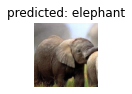

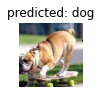

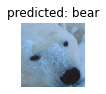

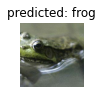

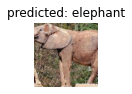

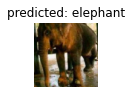

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()